# Quantization aware training of LSM using a Differentiable Quantization Function

### Submission by Abhijat Bharadwaj (210020002), Animesh Kumar (21D070012), Aditya Kumar Roy (21D070012)

In [68]:
# !pip install snntorch
# !pip install tonic

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
import sys
sys.path.insert(0,'/content')

In [71]:
#Set device
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


### Imports

In [72]:
import tonic
from tonic import DiskCachedDataset
import tonic.transforms as transforms
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import snntorch as snn

import numpy as np
from sklearn import linear_model
import time

import matplotlib.pyplot as plt

### Differentiable Quantization Function

In [90]:
# defining funtions for QAT

def sigmoid(T,x):
  return 1/(1+np.exp(-1*T*x))

def unitStep(x):
  val = np.where(x >= 0, 1, 0)
  return val

def quantization_function(alpha = 1, beta = 1, wt=1, b=np.arange(-25,25,1), s=[1.0]*50, T=0, operation = "sigmoid"):
  # s array represents the difference
  # between adjacent quantization levels
  # b array defines their border.
  o = 0.5*np.sum(s)
  wq=0
  if len(b) != len (s):
    raise Exception(f"length of b and s are different. len-b = {len(b)}. len-s = {len(s)}")
  if operation == "unitStep":
    for i in range(len(b)):
      wq+=s[i]*unitStep(beta*wt - b[i])
    wq -=o
  elif operation == "sigmoid":
    for i in range(len(b)):
      wq+=s[i]*sigmoid(T, beta*wt - b[i])
    wq -=o
  return np.float32(alpha*wq)


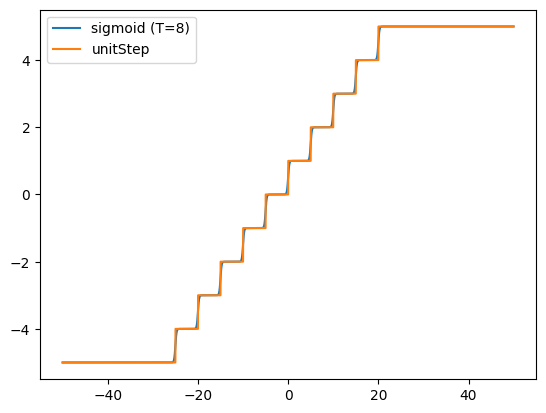

In [92]:
x = np.arange(-50,50,0.01)
y = quantization_function(
    wt = x,
    T = 8,
    b=np.arange(-25,25,5),
    s=[1.0]*10,
)
z = quantization_function(
    wt = x,
    operation = "unitStep",
    b=np.arange(-25,25,5),
    s=[1.0]*10,
)

plt.plot(x,y, label = "sigmoid (T=8)")
plt.plot(x,z, label = "unitStep" )
plt.legend()

### lsm_weight_definitions.py

In [75]:
#LSM Weight Definitions

def initWeights1(LqWin, LqWlsm, in_conn_density, in_size, lam=9, inh_fr=0.2, Nx=10, Ny=10, Nz=10, init_Wlsm=True, W_lsm=None):
    N = Nx*Ny*Nz
    W_in = np.zeros((in_size,N))
    in_conn_range = np.int32(N*in_conn_density)

    for i in range(in_size):
        input_perm_i = np.arange(N)
        np.random.shuffle(input_perm_i)
        pos_conn = input_perm_i[:in_conn_range]
        neg_conn = input_perm_i[-in_conn_range:]
        W_in[i,pos_conn] = LqWin
        W_in[i,neg_conn] = -LqWin

    input_perm = np.arange(N)
    np.random.shuffle(input_perm) # first 0.2*N indices are inhibitory
    inh_range = np.int32(inh_fr*N) # indices 0 to inh_range-1 are inhibitory

    if init_Wlsm:
        W_lsm = np.zeros((N,N))
        for i in range(N):
            posti = input_perm[i] # input_perm[i] is the post-neuron index
            zi = posti//(Nx*Ny)
            yi = (posti-zi*Nx*Ny)//Nx
            xi = (posti-zi*Nx*Ny)%Nx
        for j in range(N):
            prej = input_perm[j] # input_perm[j] is the pre-neuron index
            zj = prej//(Nx*Ny)
            yj = (prej-zj*Nx*Ny)//Nx
            xj = (prej-zj*Nx*Ny)%Nx
            D = ((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2)
            if i<inh_range and j<inh_range: # II connection, C = 0.3
                P = 0.3*np.exp(-D/lam)
                Pu1 = np.random.uniform()
                if Pu1<P:
                    W_lsm[prej,posti] = -LqWlsm
            if i<inh_range and j>=inh_range: # EI connection, C = 0.1
                P = 0.1*np.exp(-D/lam)
                Pu1 = np.random.uniform()
                if Pu1<P:
                    W_lsm[prej,posti] = LqWlsm
            if i>=inh_range and j<inh_range: # IE connection, C = 0.05
                P = 0.05*np.exp(-D/lam)
                Pu1 = np.random.uniform()
                if Pu1<P:
                    W_lsm[prej,posti] = -LqWlsm
            if i>=inh_range and j>=inh_range: # EE connection, C = 0.2
                P = 0.2*np.exp(-D/lam)
                Pu1 = np.random.uniform()
                if Pu1<P:
                    W_lsm[prej,posti] = LqWlsm

        for i in range(N):
            W_lsm[i,i] = 0

    return W_in.T,W_lsm.T #need to transpose matrices for compatibility with torch nn linear


### Extended from lsm_models.py

In [76]:
## LSM NN Model
class LSM(nn.Module):
    Temp = 0.1
    def __init__(self, N, in_sz, Win, Wlsm, alpha=0.9, beta=0.9, th=20):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, N)
        self.fc1.weight = nn.Parameter(torch.from_numpy(Win))
        self.lsm = snn.RSynaptic(alpha=alpha, beta=beta, all_to_all=True, linear_features=N, threshold=th)
        self.lsm.recurrent.weight = nn.Parameter(torch.from_numpy(Wlsm))
        self.Temp = 0.1
    def increaseT(self, increment):
        self.Temp += increment
    def forward(self, x):
        num_steps = x.size(0)
        spk, syn, mem = self.lsm.init_rsynaptic()
        spk_rec = []
        self.fc1.weight = nn.Parameter(torch.from_numpy(quantization_function(
            wt=Win,
            T=self.Temp,
        )))
        self.lsm.recurrent.weight = nn.Parameter(torch.from_numpy(quantization_function(
            wt=Wlsm,
            T=self.Temp,
        )))
        for step in range(num_steps):
            curr = self.fc1(x[step])
            spk, syn, mem = self.lsm(curr, spk, syn, mem)
            spk_rec.append(spk)
        spk_rec_out = torch.stack(spk_rec)
        return spk_rec_out

### Initializing dataset

In [77]:


#Load dataset (Using NMNIST here)
sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = transforms.Compose([transforms.Denoise(filter_time=3000),
                                      transforms.ToFrame(sensor_size=sensor_size,time_window=1000)])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 256
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

### Initializing Neuron Parameters

In [78]:
data, targets = next(iter(trainloader))
flat_data = torch.reshape(data, (data.shape[0], data.shape[1], -1))
print(flat_data.shape)

in_sz = flat_data.shape[-1]

#Set neuron parameters
tauV = 16.0
tauI = 16.0
th = 20
curr_prefac = np.float32(1/tauI)
alpha = np.float32(np.exp(-1/tauI))
beta = np.float32(1 - 1/tauV)

Win, Wlsm = initWeights1(27, 2, 0.15, in_sz)
N = Wlsm.shape[0]
lsm_net = LSM(N, in_sz, np.float32(curr_prefac*Win), np.float32(curr_prefac*Wlsm), alpha=alpha, beta=beta, th=th).to(device)
lsm_net.eval()

torch.Size([309, 256, 2312])


LSM(
  (fc1): Linear(in_features=2312, out_features=1000, bias=True)
  (lsm): RSynaptic(
    (recurrent): Linear(in_features=1000, out_features=1000, bias=True)
  )
)

### Comparision of initialized weights and quantized form

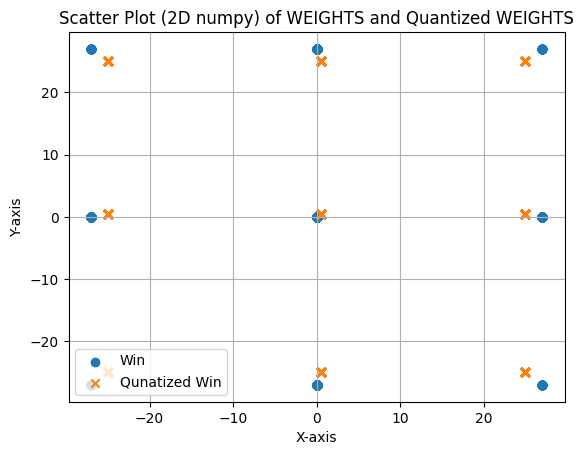

In [79]:
array1 = Win  # Replace this with your first 2D array
array2 =quantization_function(
    wt = Win,
    operation = "sigmoid",
    T=2.5
)

# Extract x and y coordinates from each array
x1, y1 = array1[:, 0], array1[:, 1]
x2, y2 = array2[:, 0], array2[:, 1]

plt.scatter(x1, y1, label='Win', marker='o')
plt.scatter(x2, y2, label='Qunatized Win', marker='x')

# Customize the plot
plt.title('Scatter Plot (2D numpy) of WEIGHTS and Quantized WEIGHTS')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)


### Train and Test

In [80]:
#Run with no_grad for LSM
with torch.no_grad():
    start_time = time.time()
    for i, (data, targets) in enumerate(iter(trainloader)):
        print(i)
        if i%25 == 24:
            print("train batches completed: ", i)

        lsm_net.increaseT(0.1)
        flat_data = torch.reshape(data, (data.shape[0], data.shape[1], -1)).to(device)
        spk_rec = lsm_net(flat_data)
        lsm_out = torch.mean(spk_rec, dim=0)
        if i==0:
            in_train = torch.mean(flat_data, dim=0).cpu().numpy()
            lsm_out_train = lsm_out.cpu().numpy()
            lsm_label_train = np.int32(targets.numpy())
        else:
            in_train = np.concatenate((in_train, torch.mean(flat_data, dim=0).cpu().numpy()), axis=0)
            lsm_out_train = np.concatenate((lsm_out_train, lsm_out.cpu().numpy()), axis=0)
            lsm_label_train = np.concatenate((lsm_label_train, np.int32(targets.numpy())), axis=0)
    end_time = time.time()

    print("running time of training epoch: ", end_time - start_time, "seconds")

    for i, (data, targets) in enumerate(iter(testloader)):
        if i%25 == 24:
            print("test batches completed: ", i)

        flat_data = torch.reshape(data, (data.shape[0], data.shape[1], -1)).to(device)
        lsm_net.eval()
        spk_rec = lsm_net(flat_data)
        lsm_out = torch.mean(spk_rec, dim=0)
        if i==0:
            in_test = torch.mean(flat_data, dim=0).cpu().numpy()
            lsm_out_test = lsm_out.cpu().numpy()
            lsm_label_test = np.int32(targets.numpy())
        else:
            in_test = np.concatenate((in_test, torch.mean(flat_data, dim=0).cpu().numpy()), axis=0)
            lsm_out_test = np.concatenate((lsm_out_test, lsm_out.cpu().numpy()), axis=0)
            lsm_label_test = np.concatenate((lsm_label_test, np.int32(targets.numpy())), axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
train batches completed:  24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
train batches completed:  49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
train batches completed:  74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
train batches completed:  99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
train batches completed:  124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


<ipython-input-73-a4bf7b7d54aa>:4: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-1*T*x))


139
140
141
142
143
144
145
146
147
148
149
train batches completed:  149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
train batches completed:  174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
train batches completed:  199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
train batches completed:  224
225
226
227
228
229
230
231
232
233
234
running time of training epoch:  5849.296909332275 seconds
test batches completed:  24


In [81]:
print(lsm_out_train.shape)
print(lsm_out_test.shape)

print(in_train.shape)
print(in_test.shape)

print("mean in spiking (train) : ", np.mean(in_train))
print("mean in spiking (test) : ", np.mean(in_test))

print("mean LSM spiking (train) : ", np.mean(lsm_out_train))
print("mean LSM spiking (test) : ", np.mean(lsm_out_test))

print("training linear model:")
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(lsm_out_train, lsm_label_train)

score = clf.score(lsm_out_test, lsm_label_test)
print("test score = " + str(score))

(60000, 1000)
(10000, 1000)
(60000, 2312)
(10000, 2312)
mean in spiking (train) :  0.004516701
mean in spiking (test) :  0.0045433217
mean LSM spiking (train) :  0.99746835
mean LSM spiking (test) :  0.9973991
training linear model:
test score = 0.0974
